### Observed dryspells and correlation with forecasted dry spells
Process the observed dryspell list as outputed by `malawi/scripts/mwi_chirps_dry_spell_detection.R` and correlate the occurence of a dry spell with the forecasted CHIRPS-GEFS dry spell

As first analysis we are focussing on the sole occurence of a dry spell per admin2. This can be extended to e.g. duration, number of dry spells, and geographical spread

For simplicity we are only focusing on forecasting the first 15 days of a dry spell, i.e. the start date of the dry spell corresponds with the start date of the forecast   
This might be too simple, e.g. might want to forecast if a dry spell that already started will persist.

For now this means that if the start_date of the forecast occurs in the dry spell list, we classify it is a true positive

Assumptions
- We want to forecast the start of a dry spell, not if a dry spell persists
- The grid cell size is small enough to only look at cells with their centre within the region, not those touching

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterstats import zonal_stats
import rasterio
from rasterio.enums import Resampling
import matplotlib
import matplotlib.colors as mcolors
import xarray as xr
import cftime
import math
import rioxarray
from shapely.geometry import mapping
import cartopy.crs as ccrs
import matplotlib as mpl
import datetime
from datetime import timedelta
import re
import seaborn as sns
import calendar

In [2]:
from pathlib import Path
import sys
import os

path_mod = f"{Path(os.path.dirname(os.path.abspath(''))).parents[1]}/"
# print(path_mod)
sys.path.append(path_mod)
from src.indicators.drought.config import Config
from src.utils_general.utils import download_ftp,download_url
from src.utils_general.raster_manipulation import fix_calendar, invert_latlon, change_longitude_range
from src.utils_general.plotting import plot_raster_boundaries_clip,plot_spatial_columns

#### Set config values

In [3]:
country="malawi"
config=Config()
parameters = config.parameters(country)
country_dir = os.path.join(config.DIR_PATH, config.ANALYSES_DIR, country)
country_data_raw_dir = os.path.join(config.DATA_DIR,config.RAW_DIR,country)
country_data_processed_dir = os.path.join(config.DATA_DIR,config.PROCESSED_DIR,country)
country_data_exploration_dir = os.path.join(config.DATA_DIR,"exploration",country)
drought_data_exploration_dir= os.path.join(config.DATA_DIR, "exploration",  'drought')
cams_data_dir=os.path.join(drought_data_exploration_dir,"CAMS_OPI")
cams_tercile_path=os.path.join(cams_data_dir,"CAMS_tercile.nc")
chirps_monthly_dir=os.path.join(drought_data_exploration_dir,"CHIRPS")
chirps_monthly_path=os.path.join(chirps_monthly_dir,"chirps_global_monthly.nc")

chirpsgefs_dir = os.path.join(config.DROUGHTDATA_DIR,"chirps_gefs")

adm1_bound_path=os.path.join(country_data_raw_dir,config.SHAPEFILE_DIR,parameters["path_admin1_shp"])
adm2_bound_path=os.path.join(country_data_raw_dir,config.SHAPEFILE_DIR,parameters["path_admin2_shp"])

#### Load CHIRPS-GEFS data

In [49]:
hist_path=os.path.join(country_data_exploration_dir,"chirpsgefs","mwi_chirpsgefs_rainyseas_stats.csv")
df_chirpsgefs=pd.read_csv(hist_path)
df_chirpsgefs["date"]=pd.to_datetime(df_chirpsgefs["date"])
df_chirpsgefs["date_forec_end"]=pd.to_datetime(df_chirpsgefs["date_forec_end"])

In [50]:
#05-03-2021: chirpsgefs data before 2010 isn't yet complete--> focus on data from 2010 for now to circumvent biases
df_chirpsgefs=df_chirpsgefs[df_chirpsgefs.date.dt.year>=2010]

In [51]:
cg_stats=["max_cell","mean_cell","min_cell","perc_se2","perc_se10"]

In [52]:
len(df_chirpsgefs)

56129

In [53]:
len(df_chirpsgefs.date.unique())

2361

In [54]:
df_chirpsgefs.date.dt.month.unique()

array([ 1,  2,  3,  4, 11, 12,  5,  6])

In [55]:
len(df_chirpsgefs.ADM2_EN.unique())

32

In [56]:
df_chirpsgefs

,Shape_Leng,Shape_Area,ADM2_EN,ADM2_PCODE,ADM2_REF,ADM2ALT1EN,ADM2ALT2EN,ADM1_EN,ADM1_PCODE,ADM0_EN,ADM0_PCODE,date,validOn,validTo,max_cell,min_cell,mean_cell,perc_se2,perc_se10,date_forec_end
0,2.036817,0.179379,Balaka,MW312,NaN,NaN,NaN,Southern,MW3,Malawi,MW,2010-01-01,2018-10-16,NaN,110.701851,61.047474,90.856951,0.0,0.0,2010-01-15
1,2.036817,0.179379,Balaka,MW312,NaN,NaN,NaN,Southern,MW3,Malawi,MW,2010-01-02,2018-10-16,NaN,109.483276,63.465965,87.865082,0.0,0.0,2010-01-16
2,2.036817,0.179379,Balaka,MW312,NaN,NaN,NaN,Southern,MW3,Malawi,MW,2010-01-03,2018-10-16,NaN,79.511253,37.181541,67.496330,0.0,0.0,2010-01-17
3,2.036817,0.179379,Balaka,MW312,NaN,NaN,NaN,Southern,MW3,Malawi,MW,2010-01-04,2018-10-16,NaN,73.974342,28.563692,51.331289,0.0,0.0,2010-01-18
4,2.036817,0.179379,Balaka,MW312,NaN,NaN,NaN,Southern,MW3,Malawi,MW,2010-01-05,2018-10-16,NaN,74.862259,41.750759,58.386692,0.0,0.0,2010-01-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56124,0.295003,0.003375,Zomba City,MW314,NaN,NaN,NaN,Southern,MW3,Malawi,MW,2021-02-26,2018-10-16,NaN,128.378326,128.378326,128.378326,0.0,0.0,2021-03-12
56125,0.295003,0.003375,Zomba City,MW314,NaN,NaN,NaN,Southern,MW3,Malawi,MW,2021-02-27,2018-10-16,NaN,65.947578,65.947578,65.947578,0.0,0.0,2021-03-13
56126,0.295003,0.003375,Zomba City,MW314,NaN,NaN,NaN,Southern,MW3,Malawi,MW,2021-02-28,2018-10-16,NaN,5.885317,5.885317,5.885317,0.0,100.0,2021-03-14
56127,0.295003,0.003375,Zomba City,MW314,NaN,NaN,NaN,Southern,MW3,Malawi,MW,2021-03-01,2018-10-16,NaN,0.000000,0.000000,0.000000,100.0,100.0,2021-03-15


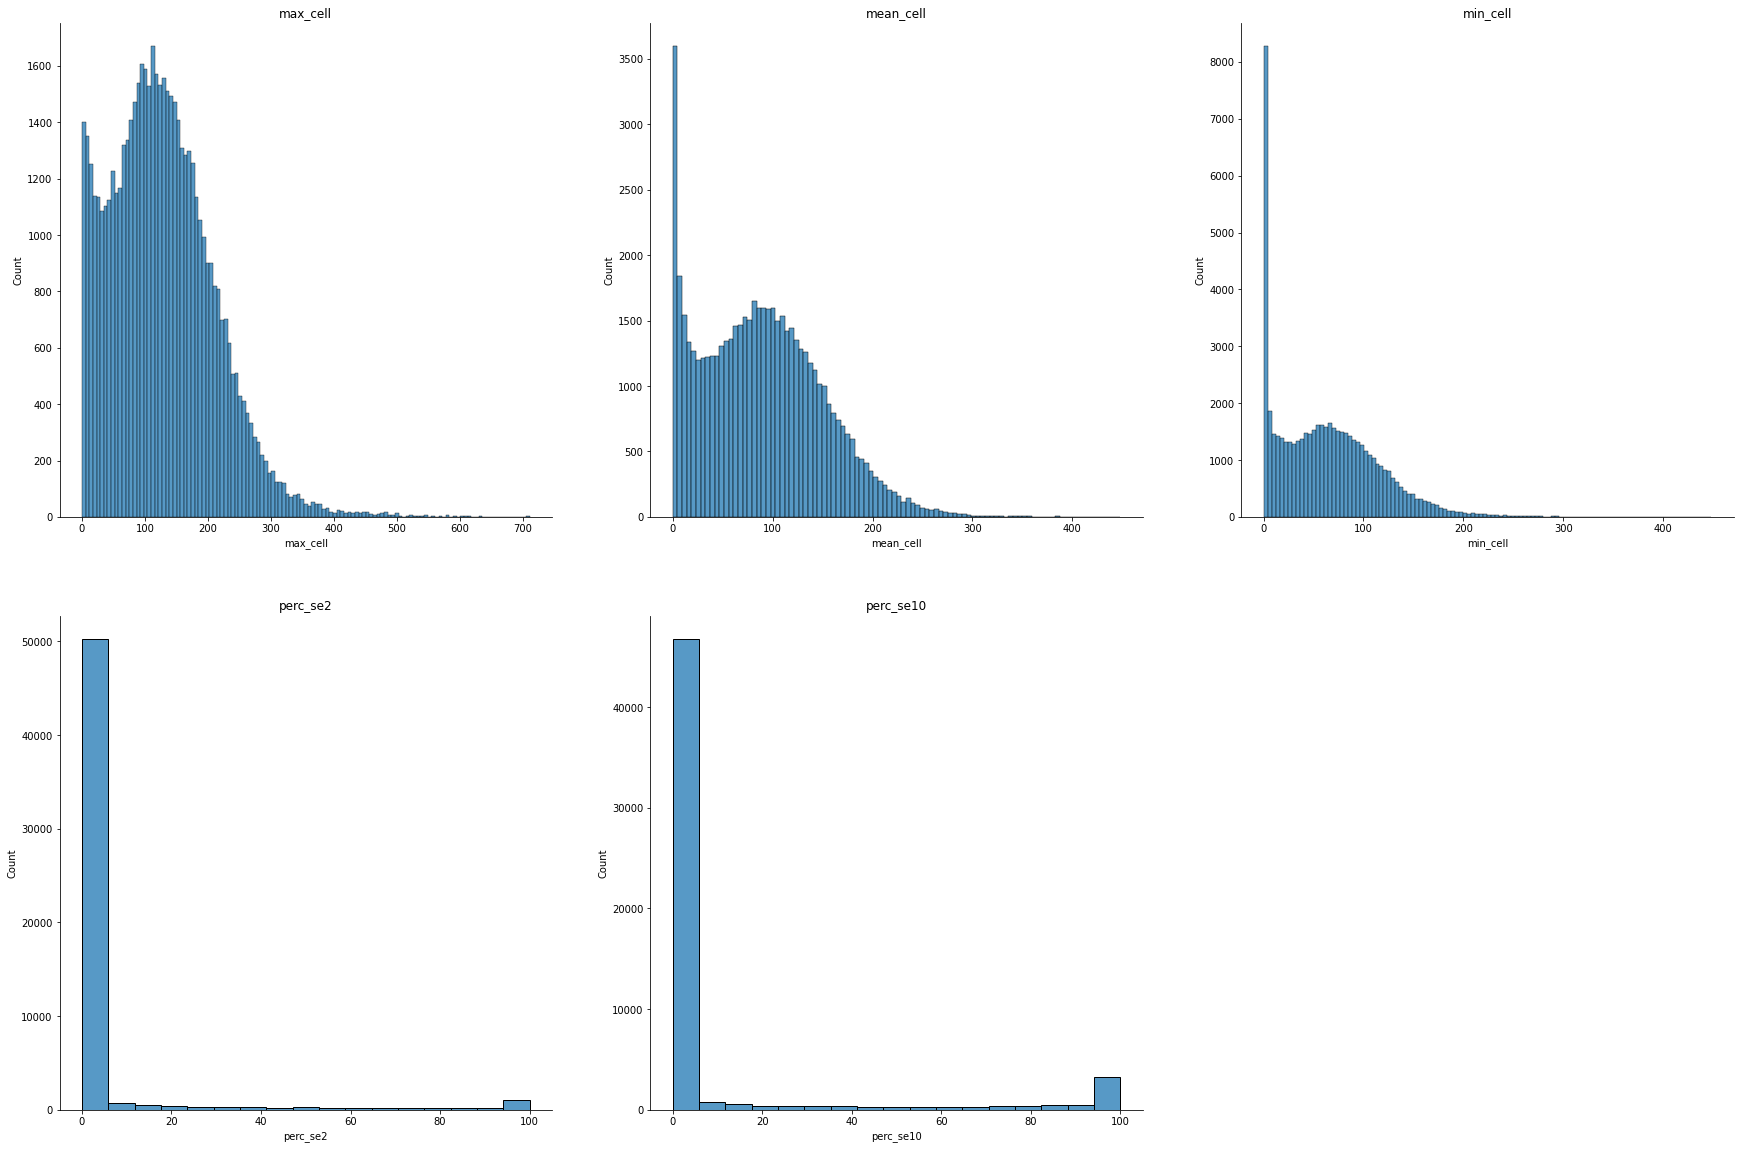

In [57]:
num_plots = len(cg_stats)
colp_num=3
if num_plots==1:
    colp_num=1
rows = math.ceil(num_plots / colp_num)
position = range(1, num_plots + 1)
fig=plt.figure(figsize=(30,20))
for i, s in enumerate(cg_stats):
    ax = fig.add_subplot(rows,colp_num,i+1)
    sns.histplot(df_chirpsgefs,x=s,ax=ax)
    ax.set_title(s)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

In [58]:
# print("number of adm2-date combination with max cell <=2mm:",len(df_chirpsgefs[df_chirpsgefs.max_cell<=2]))
# print("number of dates with at least one adm2 with max cell <=2mm:",len(df_chirpsgefs[df_chirpsgefs.max_cell<=2].date.unique()))
# print("number of adm2-date combination with mean cell <=2mm:",len(df_chirpsgefs[df_chirpsgefs.mean_cell<=2]))
# print("number of dates with at least one adm2 with mean cell <=2mm:",len(df_chirpsgefs[df_chirpsgefs.mean_cell<=2].date.unique()))

#### Load observed dry spells

In [59]:
#different methodologies of computing the observed dry spells 
#set the one being used, dryspell_obs_suffix determines which file to load
dryspell_obs_stat="mean" #"max"
if dryspell_obs_stat=="max":
    dryspell_obs_suffix=""
else:
    dryspell_obs_suffix=f"_{dryspell_obs_stat}"


df_ds=pd.read_csv(os.path.join(country_data_processed_dir,"dry_spells",f"dry_spells_during_rainy_season_list_2000_2020{dryspell_obs_suffix}.csv"))
df_ds["dry_spell_first_date"]=pd.to_datetime(df_ds["dry_spell_first_date"])
df_ds["dry_spell_last_date"]=pd.to_datetime(df_ds["dry_spell_last_date"])
df_ds["year"]=df_ds.dry_spell_first_date.dt.year

In [60]:
df_ds

,pcode,ADM2_EN,season_approx,dry_spell_first_date,dry_spell_last_date,dry_spell_duration,dry_spell_rainfall,region,year
0,MW101,Chitipa,2008,2009-04-07,2009-05-03,27,1.8,Northern,2009
1,MW103,Nkhata Bay,2001,2002-04-19,2002-05-19,31,3.4,Northern,2002
2,MW103,Nkhata Bay,2008,2009-04-06,2009-05-03,28,1.7,Northern,2009
3,MW104,Rumphi,2005,2006-04-17,2006-04-30,14,0.1,Northern,2006
4,MW105,Mzimba,2005,2006-04-17,2006-05-15,29,2.0,Northern,2006
...,...,...,...,...,...,...,...,...,...
127,MW315,Blantyre City,2001,2002-03-24,2002-04-06,14,0.0,Southern,2002
128,MW315,Blantyre City,2007,2008-02-10,2008-02-24,15,0.0,Southern,2008
129,MW315,Blantyre City,2008,2009-04-04,2009-05-03,30,0.0,Southern,2009
130,MW315,Blantyre City,2014,2015-04-01,2015-04-15,15,2.0,Southern,2015


In [61]:
#number of historically observed dry spells
#this is waay less than the predicted..
len(df_ds)

132

In [62]:
len(df_ds[df_ds.dry_spell_first_date.dt.year>=2010])

74

In [63]:
#chirpsgefs 2020 data is not complete, so these might be removed
len(df_ds[df_ds.dry_spell_first_date.dt.year==2020])

6

<Figure size 432x288 with 0 Axes>

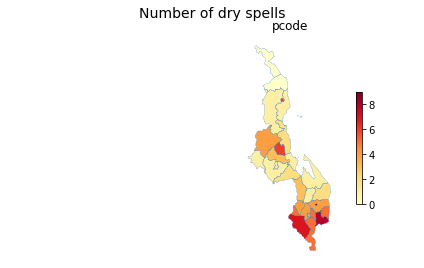

In [64]:
df_ds_adm2=df_ds.groupby(["ADM2_EN"],as_index=False).count()
df_bound_adm2=gpd.read_file(adm2_bound_path)
gdf_ds_adm2=df_bound_adm2.merge(df_ds_adm2)#.merge(df_bound_adm2)

fig=plot_spatial_columns(gdf_ds_adm2, ["pcode"], title="Number of dry spells", predef_bins=None,cmap='YlOrRd',colp_num=1)

Text(0, 0.5, 'Number of dry spells')

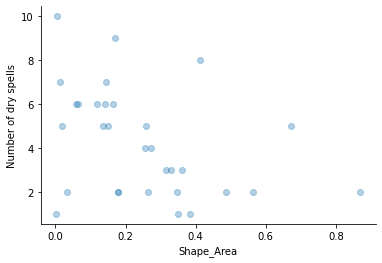

In [65]:
#check correlation with size of area and number of dry spells
g=sns.regplot(data=gdf_ds_adm2,y="pcode",x="Shape_Area",scatter_kws = {'alpha' : 1/3},fit_reg=False)
ax=g.axes
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("Number of dry spells")

In [66]:
#compute years with a dry spell compared to total number of dry spells per admin2
# df_ds_adm2_year=df_ds.drop_duplicates(["year","ADM2_EN"]).groupby("ADM2_EN",as_index=False).count()
# gdf_ds_adm2_year=df_bound_adm2.merge(df_ds_adm2_year)
# fig=plot_spatial_columns(gdf_ds_adm2_year, ["pcode"], title="Number of dry spells", predef_bins=None,cmap='YlOrRd',colp_num=1)

### Observed dryspells and correlation with forecasted dry spells

In [67]:
#combine chirpsgefs and observed dryspells data
#merge on right to include all adm2-dates present in chirpsgefs
#df_chirpsgefs, only includes the dates per adm2 that were in a rainy season
df_comb=df_ds.merge(df_chirpsgefs[["ADM2_EN","date","date_forec_end"]+cg_stats],how="right",left_on=["dry_spell_first_date","ADM2_EN"],right_on=["date","ADM2_EN"])

In [68]:
df_comb

,pcode,ADM2_EN,season_approx,dry_spell_first_date,dry_spell_last_date,dry_spell_duration,dry_spell_rainfall,region,year,date,date_forec_end,max_cell,mean_cell,min_cell,perc_se2,perc_se10
0,NaN,Balaka,NaN,NaT,NaT,NaN,NaN,NaN,NaN,2010-01-01,2010-01-15,110.701851,90.856951,61.047474,0.0,0.0
1,NaN,Balaka,NaN,NaT,NaT,NaN,NaN,NaN,NaN,2010-01-02,2010-01-16,109.483276,87.865082,63.465965,0.0,0.0
2,NaN,Balaka,NaN,NaT,NaT,NaN,NaN,NaN,NaN,2010-01-03,2010-01-17,79.511253,67.496330,37.181541,0.0,0.0
3,NaN,Balaka,NaN,NaT,NaT,NaN,NaN,NaN,NaN,2010-01-04,2010-01-18,73.974342,51.331289,28.563692,0.0,0.0
4,NaN,Balaka,NaN,NaT,NaT,NaN,NaN,NaN,NaN,2010-01-05,2010-01-19,74.862259,58.386692,41.750759,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56124,NaN,Zomba City,NaN,NaT,NaT,NaN,NaN,NaN,NaN,2021-02-26,2021-03-12,128.378326,128.378326,128.378326,0.0,0.0
56125,NaN,Zomba City,NaN,NaT,NaT,NaN,NaN,NaN,NaN,2021-02-27,2021-03-13,65.947578,65.947578,65.947578,0.0,0.0
56126,NaN,Zomba City,NaN,NaT,NaT,NaN,NaN,NaN,NaN,2021-02-28,2021-03-14,5.885317,5.885317,5.885317,0.0,100.0
56127,NaN,Zomba City,NaN,NaT,NaT,NaN,NaN,NaN,NaN,2021-03-01,2021-03-15,0.000000,0.000000,0.000000,100.0,100.0


In [69]:
#nan = there was a forecast but no observed dry spell--> set occurence of dry spell to zero
#again, only looking at if any dry spell started on that date, not whether it persisted
df_comb["dryspell_obs"]=np.where(df_comb.dry_spell_first_date.notna(),1,0)

In [99]:
# Aaah somehow dry spells went missing when merging on the forecast list
#reason not all data till 2010 is included yet and part of data 2020 is missing..
#TODO: check how (might have to do with missing data in 2020..)
len(df_comb[df_comb.dryspell_obs==1])

68

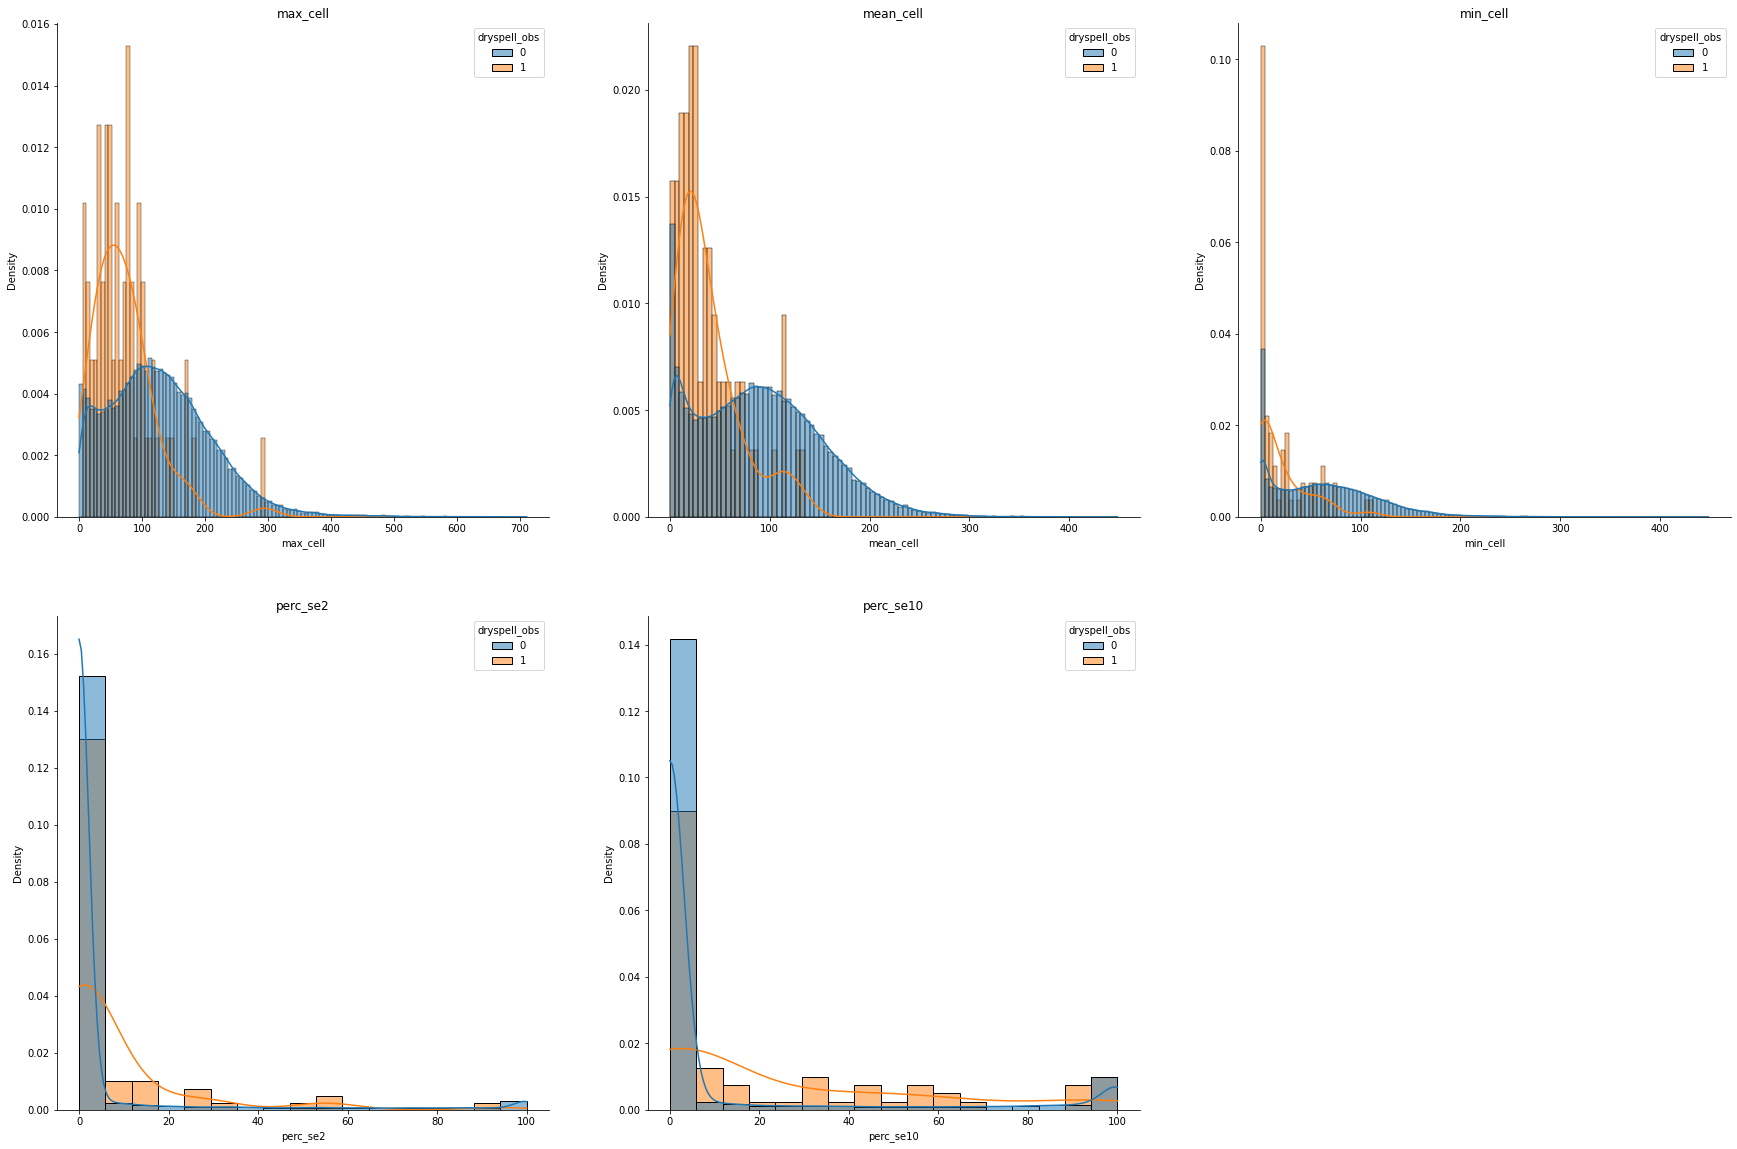

In [70]:
num_plots = len(cg_stats)
colp_num=3
if num_plots==1:
    colp_num=1
rows = math.ceil(num_plots / colp_num)
position = range(1, num_plots + 1)
fig=plt.figure(figsize=(30,20))
for i, s in enumerate(cg_stats):
    ax = fig.add_subplot(rows,colp_num,i+1)
    sns.histplot(df_comb,x=s,ax=ax,stat="density",common_norm=False,kde=True,hue="dryspell_obs")
    ax.set_title(s)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

#### Plot raw raster values
Of CHIRPS-GEFS for dates where there is an observed dry spell

In [32]:
#load the raster data
ds_list=[]
for d in df_comb[df_comb.dryspell_obs==1].date.unique():
    d_str=pd.to_datetime(d).strftime("%Y%m%d")
    filename=f"chirpsgefs_africa_{d_str}.tif"
    rds=rioxarray.open_rasterio(os.path.join(chirpsgefs_dir,filename))
    rds=rds.assign_coords({"time":pd.to_datetime(d)})
    rds=rds.sel(band=1)
    ds_list.append(rds)

ds_drys=xr.concat(ds_list,dim="time")

ds_drys=ds_drys.sortby("time")

In [33]:
ds_list[0]

<xarray.DataArray (y: 1600, x: 1500)>
[2400000 values with dtype=float32]
Coordinates:
    band         int64 1
  * y            (y) float64 39.97 39.92 39.87 39.82 ... -39.88 -39.93 -39.98
  * x            (x) float64 -19.97 -19.92 -19.87 -19.82 ... 54.88 54.93 54.98
    spatial_ref  int64 0
    time         datetime64[ns] 2012-04-02
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    grid_mapping:  spatial_ref

Balaka
Blantyre
Blantyre City
Chikwawa
Chiradzulu
Dedza
Dowa
Kasungu
Lilongwe
Lilongwe City
Machinga
Mangochi
Mchinji
Mulanje
Mwanza
Mzimba
Mzuzu City
Neno
Nkhotakota
Nsanje
Ntcheu
Ntchisi
Phalombe
Thyolo
Zomba


/Users/tinkavalentijn/.virtualenvs/antact/lib/python3.8/site-packages/xarray/plot/facetgrid.py:164: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(


Zomba City


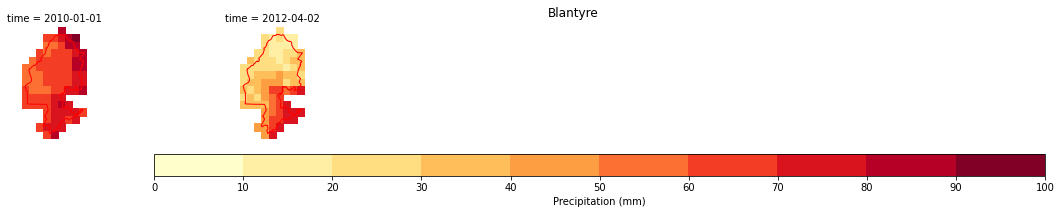

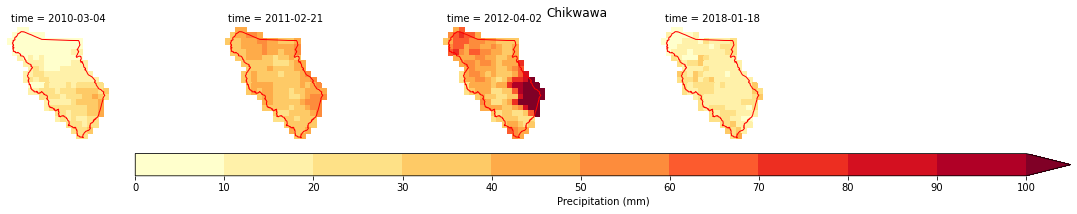

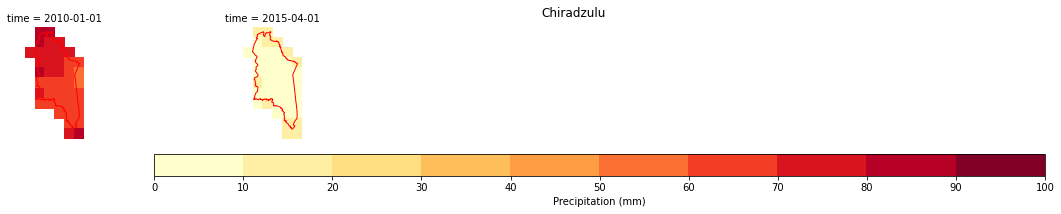

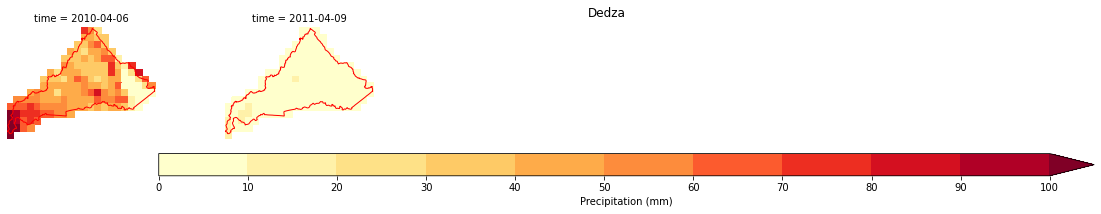

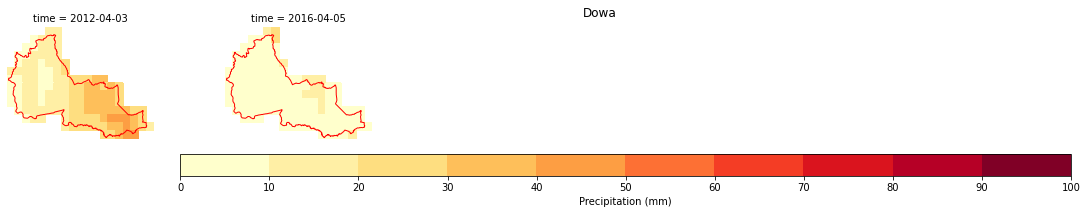

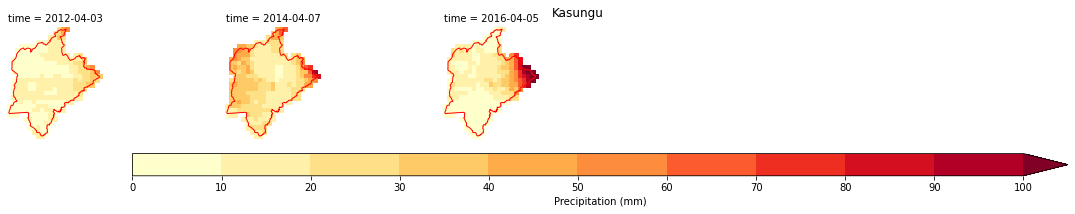

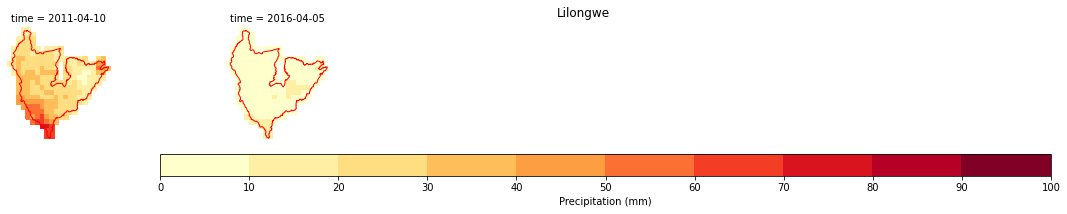

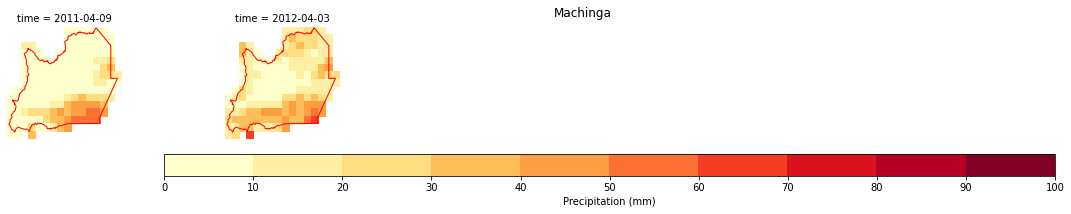

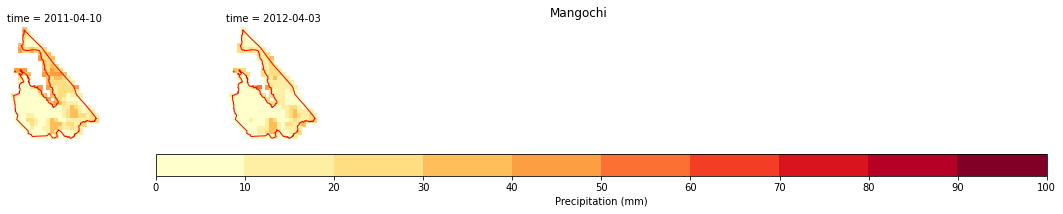

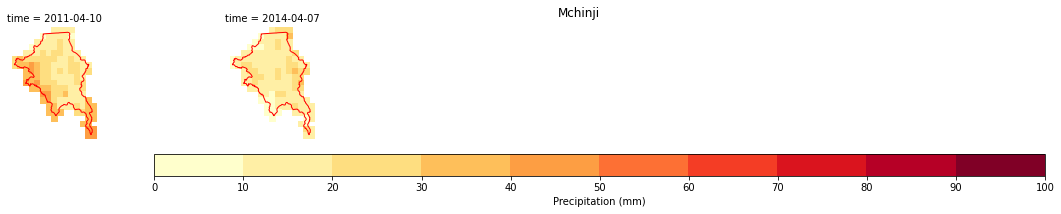

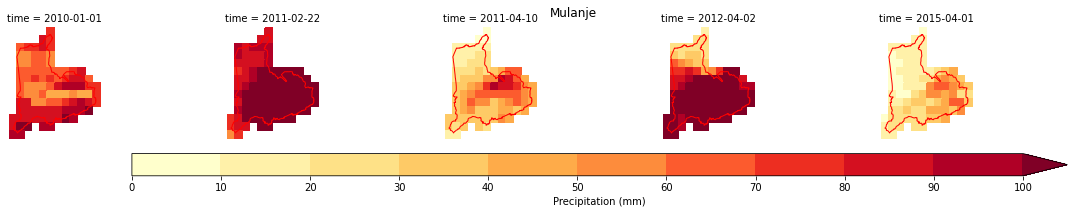

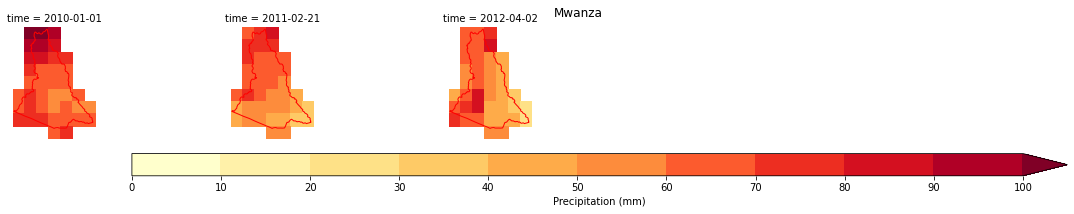

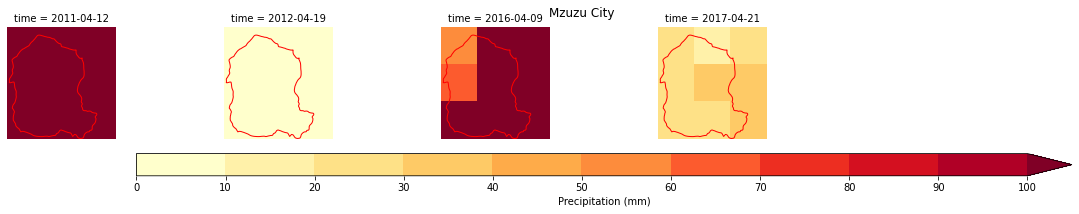

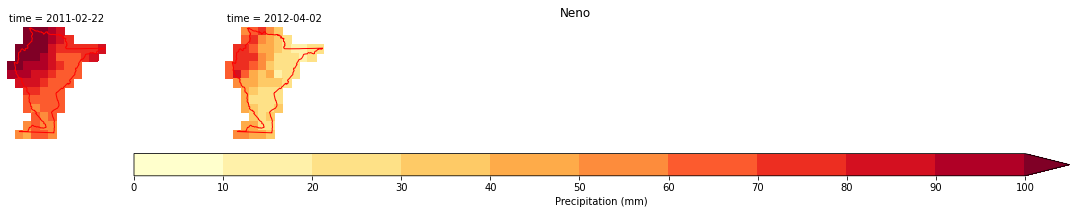

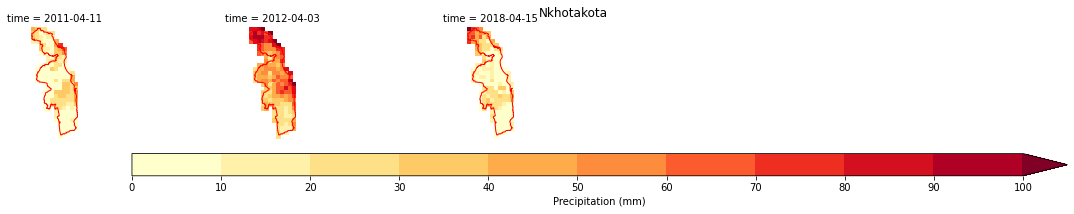

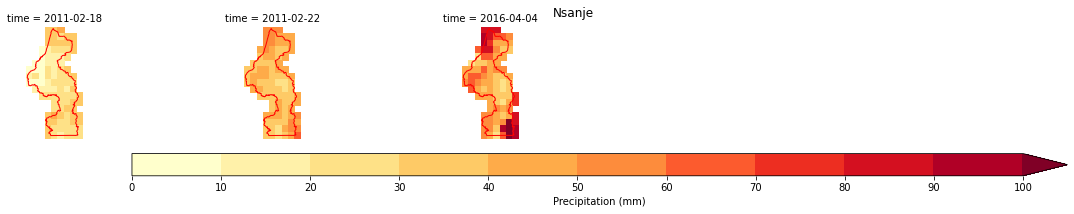

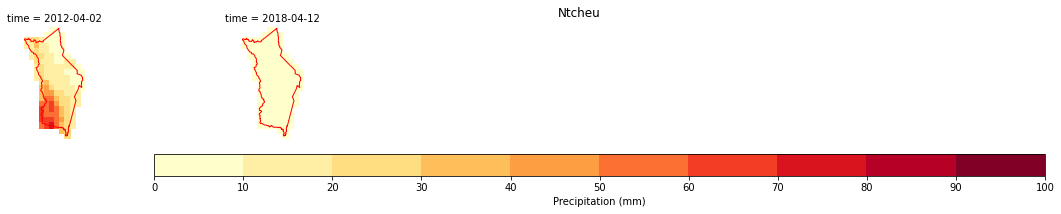

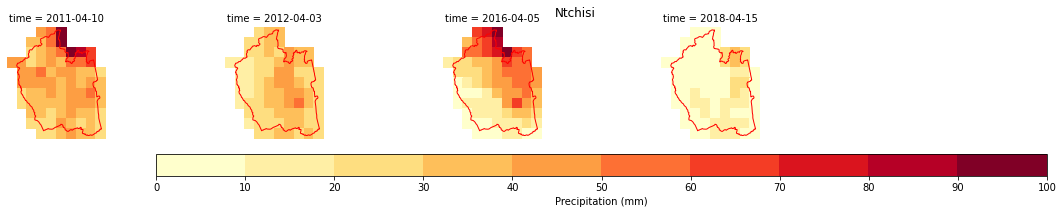

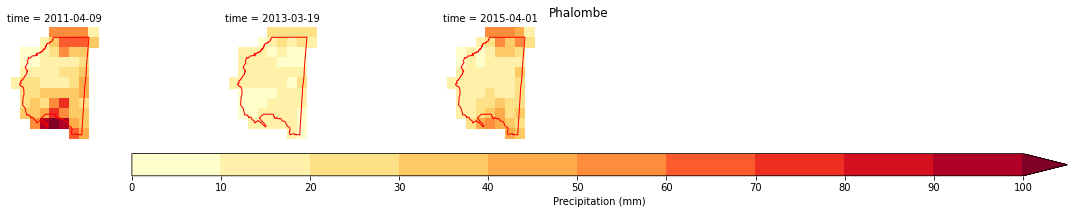

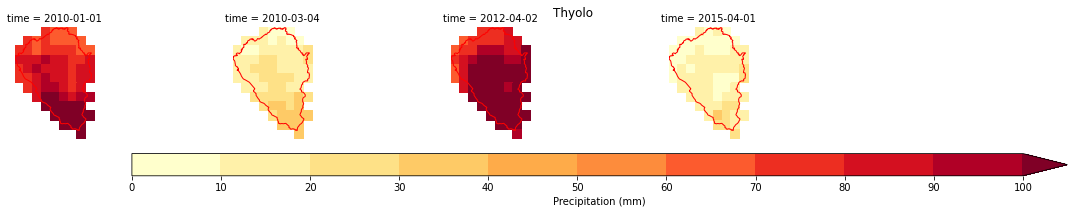

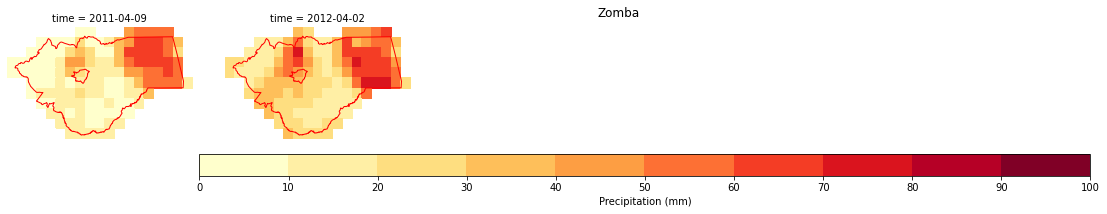

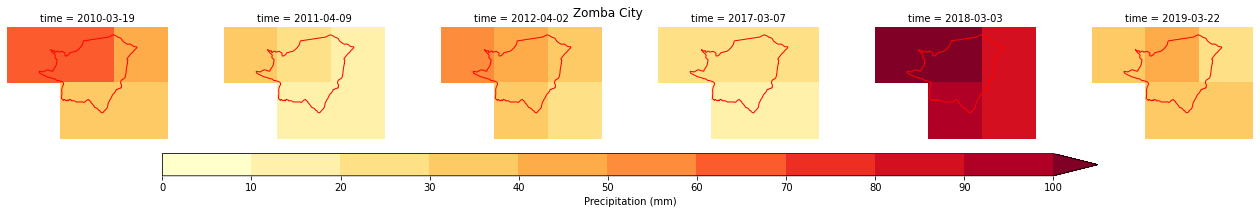

In [38]:
#plot the rasters. Plot per adm2
ds_drys_clip = ds_drys.rio.clip(df_bound_adm2.geometry.apply(mapping), df_bound_adm2.crs, all_touched=True)
bins=np.arange(0,101,10)

# ds_drys_clip.values[~np.isnan(ds_drys_clip.values)].max()

df_comb_ds=df_comb[df_comb.dryspell_obs==1]
for a in df_comb_ds.ADM2_EN.unique():
    print(a)
    df_bound_sel_adm=df_bound_adm2[df_bound_adm2.ADM2_EN==a]
    ds_drys_clip_adm = ds_drys.rio.clip(df_bound_sel_adm.geometry.apply(mapping), df_bound_sel_adm.crs, all_touched=True)
    ds_drys_clip_adm_dates=ds_drys_clip_adm.sel(time=ds_drys_clip_adm.time.isin(df_comb_ds[df_comb_ds.ADM2_EN==a].date.unique()))
    #cannot make the facetgrid if only one occurence. For now leave them out since just exploration, but for completeness should somehow include them
    if len(ds_drys_clip_adm_dates.time)>1:
        g=ds_drys_clip_adm_dates.plot(
        col="time",
        col_wrap=6,
        levels=bins,
        cbar_kwargs={
            "orientation": "horizontal",
            "shrink": 0.8,
            "aspect": 40,
            "pad": 0.1,
            "label":"Precipitation (mm)",
            "ticks": bins
        },
        cmap="YlOrRd",
    )

        for ax in g.axes.flat:
            df_bound_sel_adm.boundary.plot(linewidth=1, ax=ax, color="red")
            ax.axis("off")
        g.fig.suptitle(f"{a}")# {df_comb_ds[df_comb_ds.ADM2_EN==a].sort_values(by='date').dryspell_forec.values}")



### Discrepancy forecasted and observed rainfall

In [79]:
#read historically observed 14 day rolling sum for all dates (so not only those with dry spells)
df_histobs=pd.read_csv(os.path.join(country_data_processed_dir,"dry_spells","data_mean_values_long.csv"))
df_histobs.date=pd.to_datetime(df_histobs.date)

#add start of the rolling sum 
df_histobs["date_start"]=df_histobs.date-timedelta(days=14)

In [81]:
#add adm2 name
df_histobs=df_histobs.merge(df_bound_adm2[["ADM1_EN","ADM2_EN","ADM2_PCODE"]],left_on="pcode",right_on="ADM2_PCODE")

In [82]:
#merge forecast and observed
df_histformerg=df_histobs.merge(df_chirpsgefs,left_on=["date_start","ADM2_EN"],right_on=["date","ADM2_EN"],suffixes=("obs","forec"))

In [84]:
df_histformerg["diff_precip"]=df_histformerg["rollsum_15d"]-df_histformerg["mean_cell"]
df_histformerg["diff_forecobs"]=df_histformerg["mean_cell"]-df_histformerg["rollsum_15d"]

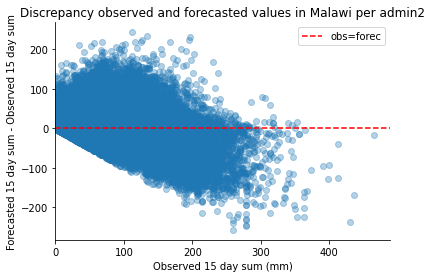

In [98]:
g=sns.regplot(data=df_histformerg,y="diff_forecobs",x="rollsum_15d",scatter_kws = {'alpha' : 1/3},fit_reg=False)
ax=g.axes
ax.set_xlabel("Observed 15 day sum (mm)")
ax.set_ylabel("Forecasted 15 day sum - Observed 15 day sum")
ax.set_title("Discrepancy observed and forecasted values in Malawi per admin2")
ax.axhline(0, ls='--',color="red",label="obs=forec")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim(0,ax.get_xlim()[1])
# ax.plot(np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],50),np.linspace(-ax.get_xlim()[0],-ax.get_xlim()[1],50),ls="--",label="forec=0")
plt.legend()
plt.savefig(os.path.join(country_data_exploration_dir,"dryspells","plot_MWI_CHIRPSGEFS_CHIRPS.png"))

In [100]:
# g=sns.regplot(data=df_histformerg,y="diff_precip",x="rollsum_15d",scatter_kws = {'alpha' : 1/3},fit_reg=False)
# ax=g.axes
# ax.set_xlabel("Observed 15 day sum (mm)")
# ax.set_ylabel("Observed 15 day sum - Forecasted 15 day sum")
# ax.set_title("Discrepancy observed and forecasted values")
# ax.axhline(0, ls='--',color="red",label="Obs=Forec")
# print(ax.get_xlim())
# ax.set_xlim(0,ax.get_xlim()[1])
# ax.plot(np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],50),np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],50),ls="--",label="Forec=0")
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# plt.legend()

Text(0.5, 1.0, 'Observed and forecasted dryspells')

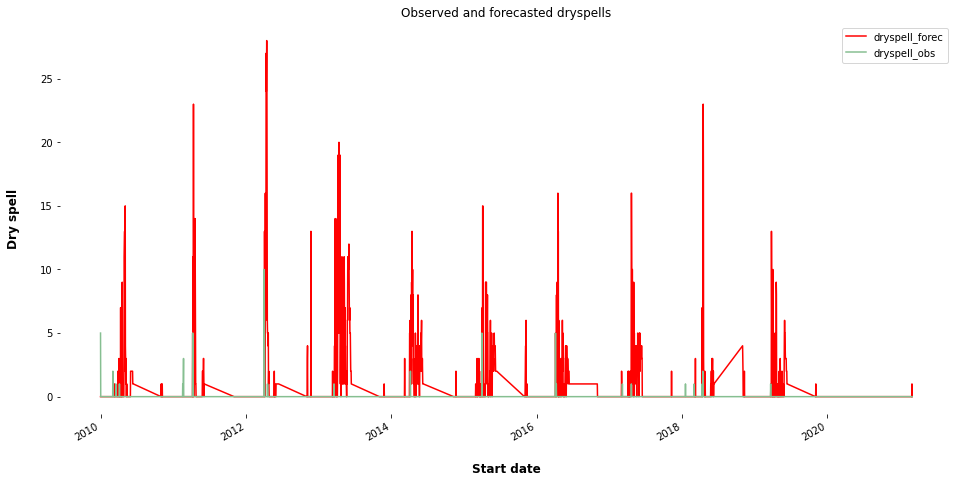

In [117]:
#number of adm2s with dryspell for forecasted and observed over time
#the diagonal lines are caused by the last day of a rainy season having a forecasted dry spell
from matplotlib.ticker import StrMethodFormatter
fig,ax=plt.subplots()
df_comb_date=df_comb.groupby("date",as_index=False).sum()
df_comb_date.sort_values(by="date").plot(x="date",y="dryspell_forec" ,figsize=(16, 8), color='red',legend=True,ax=ax)
df_comb_date.sort_values(by="date").plot(x="date",y="dryspell_obs" ,figsize=(16, 8), color='#86bf91',legend=True,ax=ax)

# Set x-axis label
ax.set_xlabel("Start date", labelpad=20, weight='bold', size=12)

# Set y-axis label
ax.set_ylabel("Dry spell", labelpad=20, weight='bold', size=12)

# Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.title(f"Observed and forecasted dryspells")

In [119]:
#understand monthly patterns observed vs forecasted
df_comb["month"]=df_comb.date.dt.month

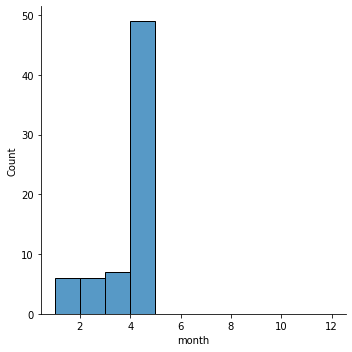

In [120]:
#observed dry spells per month
sns.displot(df_comb[df_comb.dryspell_obs==1],bins=range(df_comb.month.min(),df_comb.month.max()+1),x="month")

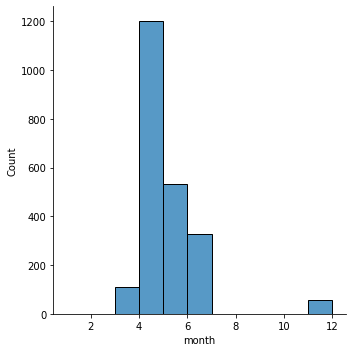

In [121]:
#forecasted dry spells per month
sns.displot(df_comb[df_comb.dryspell_forec==1],bins=range(df_comb.month.min(),df_comb.month.max()+1),x="month")

### Correlations

In [101]:
#set definition of forecasted dry spell as max cell having not more than 2 mm of rains in 15 days period
df_comb["dryspell_forec"]=np.where(df_comb.mean_cell<=2,1,0)

None of the mean cell boundaries really captures the dry spell and do results in lot of false positives.. When using the max, it doesn't get better

##### Understand differences patterns observed and forecasted dry spells
- Dry spell is at least 14 days while forecasted period is 15 days --> can be a reason for underpredicting
- [WHEN USING MAX TO COMPUTE OBSERVED DRY SPELLS] Definition of observed dry spell is stricter than forecasted --> can be a reason for overpredicting


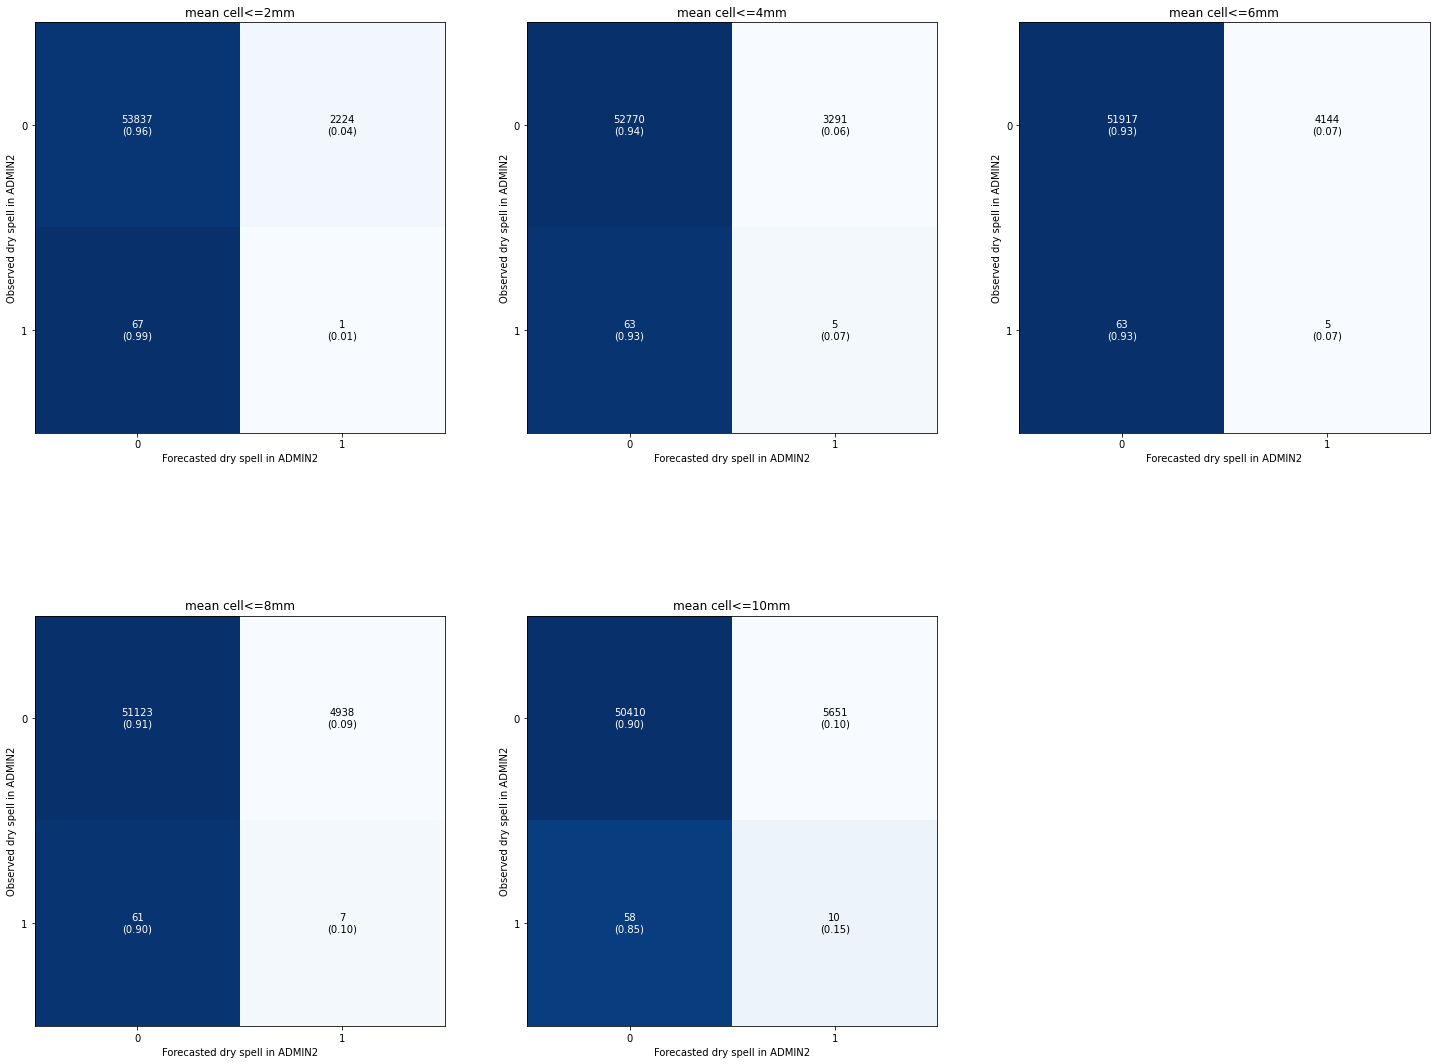

In [114]:
#compute the contigency table when using mean cell for different thresholds
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
t_list=[2,4,6,8,10]
num_plots = len(t_list)
colp_num=3
if num_plots==1:
    colp_num=1
rows = math.ceil(num_plots / colp_num)
position = range(1, num_plots + 1)
fig=plt.figure(figsize=(25,20))
for i,t in enumerate(t_list):
    y_target =    df_comb["dryspell_obs"]
    y_predicted = np.where(df_comb["mean_cell"]<=t,1,0)
    ax = fig.add_subplot(rows,colp_num,i+1)
    cm = confusion_matrix(y_target=y_target, 
                          y_predicted=y_predicted)

    plot_confusion_matrix(conf_mat=cm,show_absolute=True,show_normed=True,axis=ax) #,class_names=["No","Yes"])
    ax.set_ylabel("Observed dry spell in ADMIN2")
    ax.set_xlabel("Forecasted dry spell in ADMIN2")
    ax.set_title(f"mean cell<={t}mm")

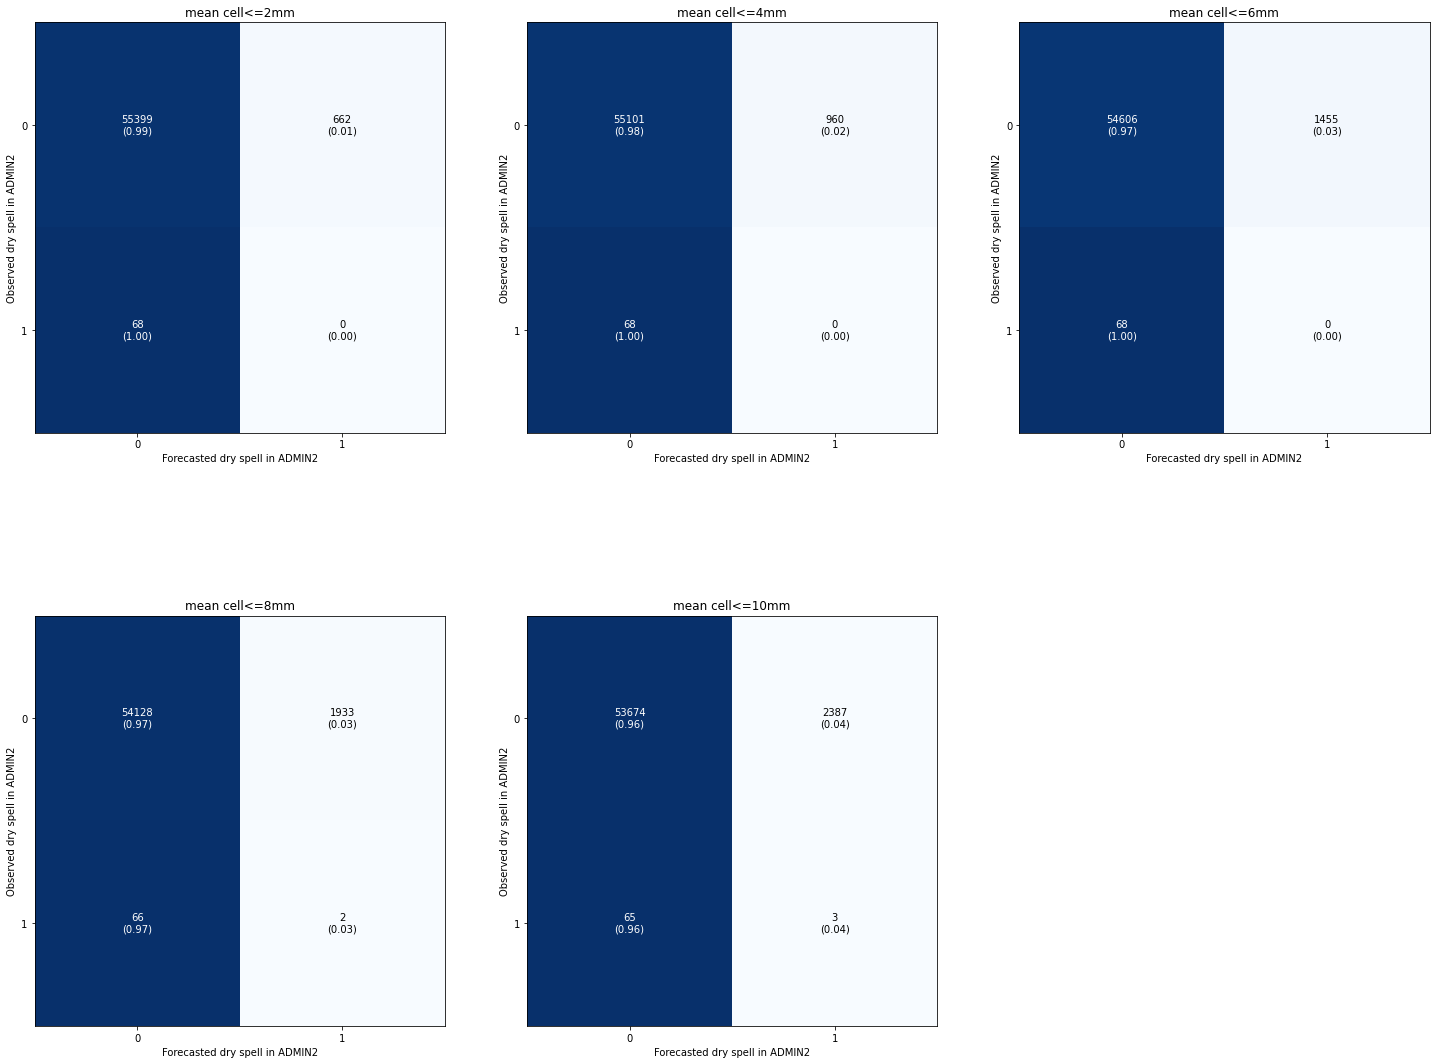

In [115]:
#compute the contigency table when using mean cell for different thresholds
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
t_list=[2,4,6,8,10]
num_plots = len(t_list)
colp_num=3
if num_plots==1:
    colp_num=1
rows = math.ceil(num_plots / colp_num)
position = range(1, num_plots + 1)
fig=plt.figure(figsize=(25,20))
for i,t in enumerate(t_list):
    y_target =    df_comb["dryspell_obs"]
    y_predicted = np.where(df_comb["max_cell"]<=t,1,0)
    ax = fig.add_subplot(rows,colp_num,i+1)
    cm = confusion_matrix(y_target=y_target, 
                          y_predicted=y_predicted)

    plot_confusion_matrix(conf_mat=cm,show_absolute=True,show_normed=True,axis=ax) #,class_names=["No","Yes"])
    ax.set_ylabel("Observed dry spell in ADMIN2")
    ax.set_xlabel("Forecasted dry spell in ADMIN2")
    ax.set_title(f"mean cell<={t}mm")

In [116]:
#sum of dryspells per adm2, doesn't mean they occured on the same dates
#could add fraction obs/forec
df_comb.groupby("ADM2_EN").sum()[["dryspell_forec","dryspell_obs"]]#.date.sort_values().unique()

,dryspell_forec,dryspell_obs
ADM2_EN,,
Balaka,88,1
Blantyre,55,2
Blantyre City,18,1
Chikwawa,52,4
Chiradzulu,40,2
Chitipa,76,0
Dedza,122,2
Dowa,111,2
Karonga,141,0


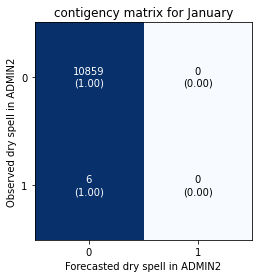

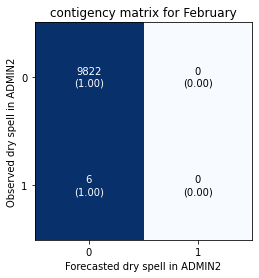

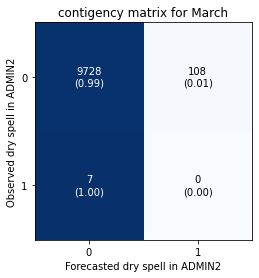

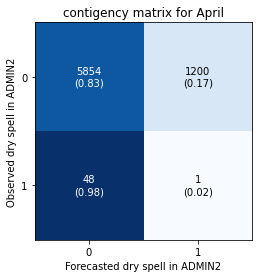

/Users/tinkavalentijn/.virtualenvs/antact/lib/python3.8/site-packages/mlxtend/plotting/plot_confusion_matrix.py:76: RuntimeWarning: invalid value encountered in true_divide
  normed_conf_mat = conf_mat.astype('float') / total_samples


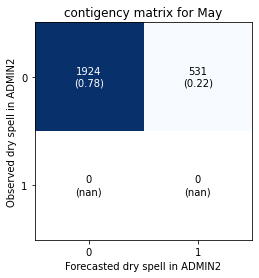

/Users/tinkavalentijn/.virtualenvs/antact/lib/python3.8/site-packages/mlxtend/plotting/plot_confusion_matrix.py:76: RuntimeWarning: invalid value encountered in true_divide
  normed_conf_mat = conf_mat.astype('float') / total_samples


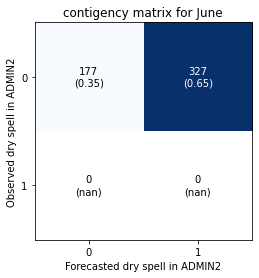

/Users/tinkavalentijn/.virtualenvs/antact/lib/python3.8/site-packages/mlxtend/plotting/plot_confusion_matrix.py:76: RuntimeWarning: invalid value encountered in true_divide
  normed_conf_mat = conf_mat.astype('float') / total_samples


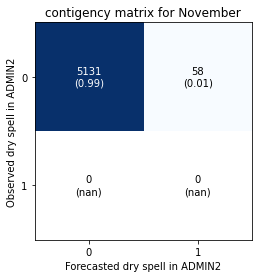

/Users/tinkavalentijn/.virtualenvs/antact/lib/python3.8/site-packages/mlxtend/plotting/plot_confusion_matrix.py:76: RuntimeWarning: invalid value encountered in true_divide
  normed_conf_mat = conf_mat.astype('float') / total_samples


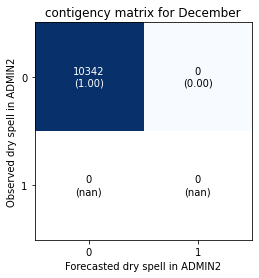

In [122]:
#compute the contigency table per month
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

for m in df_comb.sort_values(by="month").month.unique():

    y_target =    df_comb.loc[df_comb.month==m,"dryspell_obs"]
    y_predicted = df_comb.loc[df_comb.month==m,"dryspell_forec"]

    cm = confusion_matrix(y_target=y_target, 
                          y_predicted=y_predicted)
#     print(cm)
#     print(calendar.month_name[m])
#     print(f"contigency matrix for {pd.to_datetime(m).strftime('%B')}")
    fig, ax = plot_confusion_matrix(conf_mat=cm,show_absolute=True,show_normed=True) #,class_names=["No","Yes"])
    ax.set_ylabel("Observed dry spell in ADMIN2")
    ax.set_xlabel("Forecasted dry spell in ADMIN2")
#     print(m)
    ax.set_title(f"contigency matrix for {calendar.month_name[m]}")
    plt.show()

#### correlation number of admin2s with observed and forecasted dry spell

In [123]:
#compute number of adm2s with dryspell per date
df_numadm=df_comb.groupby("date")[["dryspell_obs","dryspell_forec"]].sum()

In [124]:
df_numadm

,dryspell_obs,dryspell_forec
date,,
2010-01-01,5,0
2010-01-02,0,0
2010-01-03,0,0
2010-01-04,0,0
2010-01-05,0,0
...,...,...
2021-02-26,0,0
2021-02-27,0,0
2021-02-28,0,0


<AxesSubplot:xlabel='dryspell_obs', ylabel='dryspell_forec'>

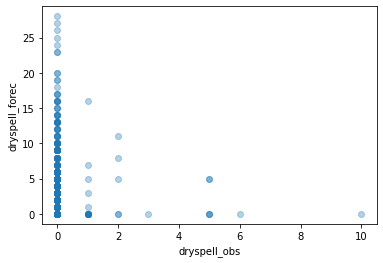

In [125]:
#darker shade means higher density of values
#-->not really clear pattern..
sns.regplot(data = df_numadm, x = 'dryspell_obs', y = 'dryspell_forec', fit_reg = False,
            scatter_kws = {'alpha' : 1/3})#,x_jitter = 0.2, y_jitter = 0.2)

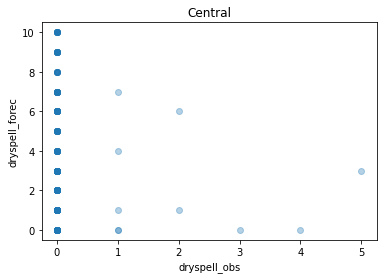

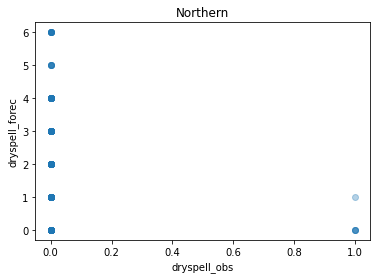

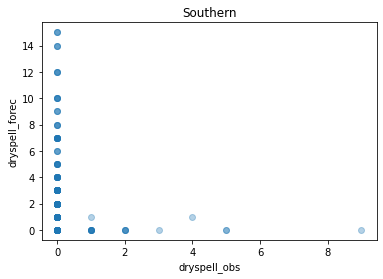

In [126]:
df_comb=df_comb.merge(df_bound_adm2[["ADM1_EN","ADM2_EN"]],on="ADM2_EN",how="left")
df_numadm1=df_comb.groupby(["date","ADM1_EN"],as_index=False)[["dryspell_obs","dryspell_forec"]].sum()

for a in df_numadm1.ADM1_EN.unique():
    g=sns.regplot(data = df_numadm1[df_numadm1.ADM1_EN==a], x = 'dryspell_obs', y = 'dryspell_forec', fit_reg = False,
            scatter_kws = {'alpha' : 1/3})#,x_jitter = 0.2, y_jitter = 0.2)
    g.axes.set_title(a)
    plt.show()

[[1840  494]
 [  17   10]]


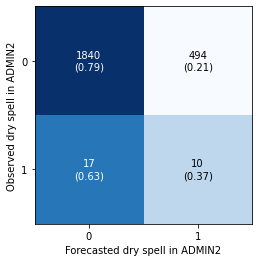

In [127]:
#compute the contigency table per date
#Damnn that correlation between obsrved and forecasted is waay less than I expected.. 
#Need to further understand why and if this is really the case or bug somewhere
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

df_comb_date=df_comb.groupby("date",as_index=False).sum()
df_comb_date["dryspell_obs_bool"]=np.where(df_comb_date.dryspell_obs>=1,1,0)
df_comb_date["dryspell_forec_bool"]=np.where(df_comb_date.dryspell_forec>=1,1,0)

y_target =    df_comb_date["dryspell_obs_bool"]
y_predicted = df_comb_date["dryspell_forec_bool"]

cm = confusion_matrix(y_target=y_target, 
                      y_predicted=y_predicted)
print(cm)

fig, ax = plot_confusion_matrix(conf_mat=cm,show_absolute=True,show_normed=True) #,class_names=["No","Yes"])
ax.set_ylabel("Observed dry spell in ADMIN2")
ax.set_xlabel("Forecasted dry spell in ADMIN2")
plt.show()

[[35 34]
 [ 3 13]]


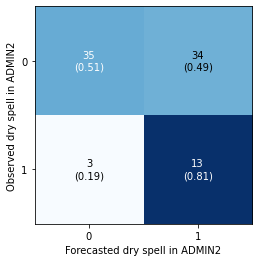

In [128]:
#compute the contigency table per date
#Damnn that correlation between obsrved and forecasted is waay less than I expected.. 
#Need to further understand why and if this is really the case or bug somewhere
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

df_comb["date_month"]=df_comb.date.dt.to_period("M")
df_comb_month=df_comb.groupby("date_month",as_index=False).sum()
df_comb_month["dryspell_obs_bool"]=np.where(df_comb_month.dryspell_obs>=1,1,0)
df_comb_month["dryspell_forec_bool"]=np.where(df_comb_month.dryspell_forec>=1,1,0)

y_target =    df_comb_month["dryspell_obs_bool"]
y_predicted = df_comb_month["dryspell_forec_bool"]

cm = confusion_matrix(y_target=y_target, 
                      y_predicted=y_predicted)
print(cm)

fig, ax = plot_confusion_matrix(conf_mat=cm,show_absolute=True,show_normed=True) #,class_names=["No","Yes"])
ax.set_ylabel("Observed dry spell in ADMIN2")
ax.set_xlabel("Forecasted dry spell in ADMIN2")
plt.show()

### Visualizing rasters 5 days

In [130]:
#load rasters
ds_list=[]
for d in df_ds.dry_spell_first_date.unique():
    d_str=pd.to_datetime(d).strftime("%Y%m%d")
    filename=f"chirpsgefs_5day_africa_{d_str}.tif"
    try:
        rds=rioxarray.open_rasterio(os.path.join(chirpsgefs_dir,filename))
        rds=rds.assign_coords({"time":pd.to_datetime(d)})
        rds=rds.sel(band=1)
        ds_list.append(rds)
    except:
        print(d_str)


ds_drys=xr.concat(ds_list,dim="time")


ds_drys=ds_drys.sortby("time")

20200226
20200302


Balaka
Blantyre
Blantyre City
Chikwawa
Chiradzulu
Dedza
Dowa
Kasungu
Lilongwe
Lilongwe City
Machinga
Mangochi
Mchinji
Mulanje
Mwanza
Mzimba
Mzuzu City
Neno
Nkhotakota
Nsanje
Ntcheu
Ntchisi
Phalombe
Thyolo
Zomba


/Users/tinkavalentijn/.virtualenvs/antact/lib/python3.8/site-packages/xarray/plot/facetgrid.py:164: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(


Zomba City


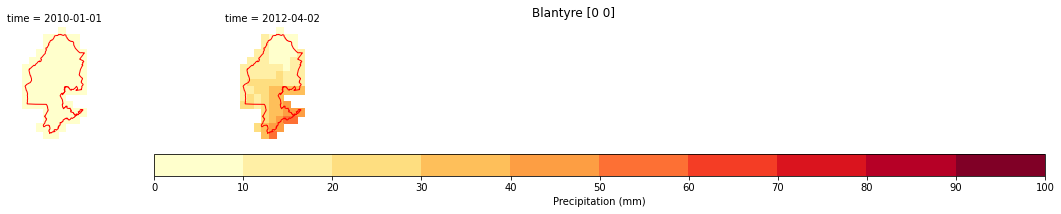

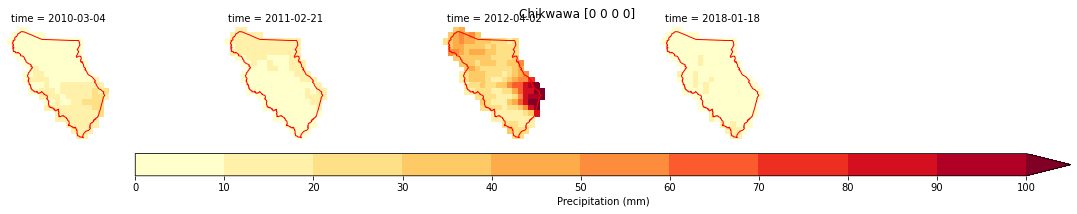

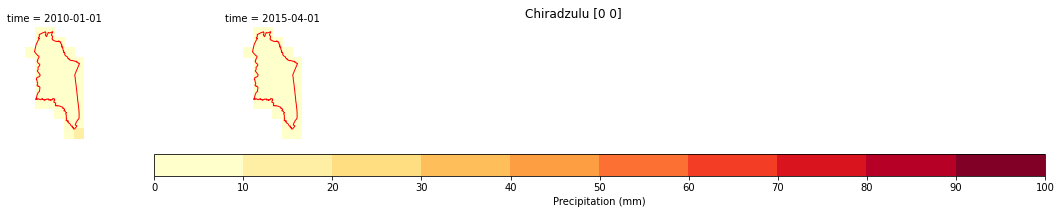

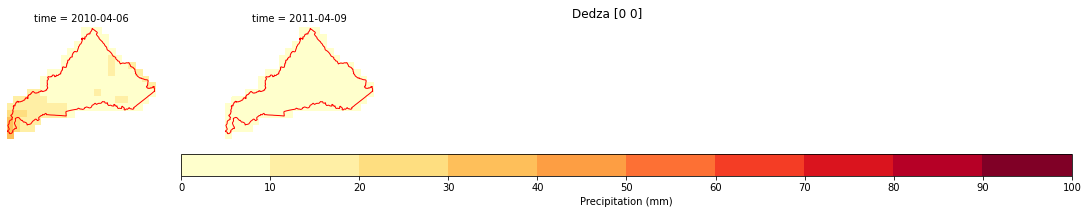

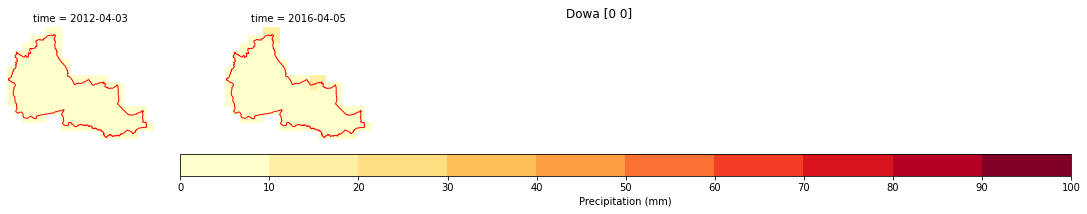

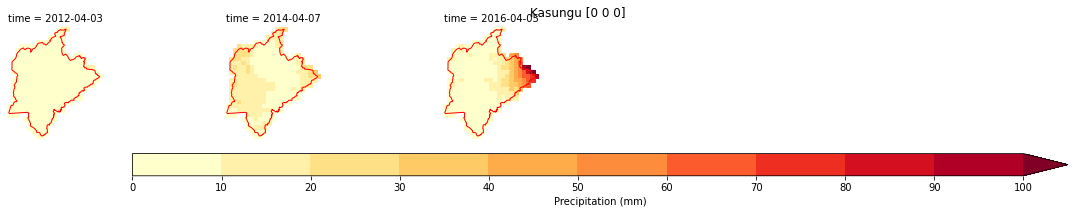

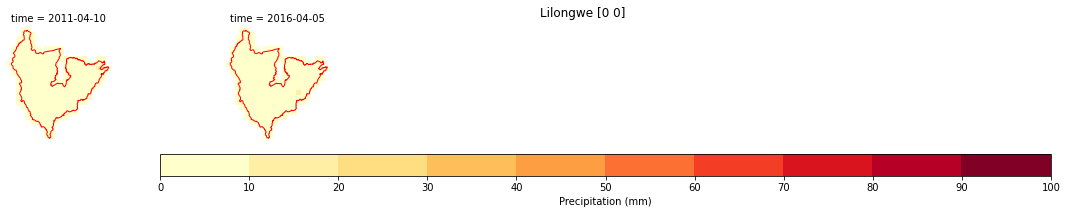

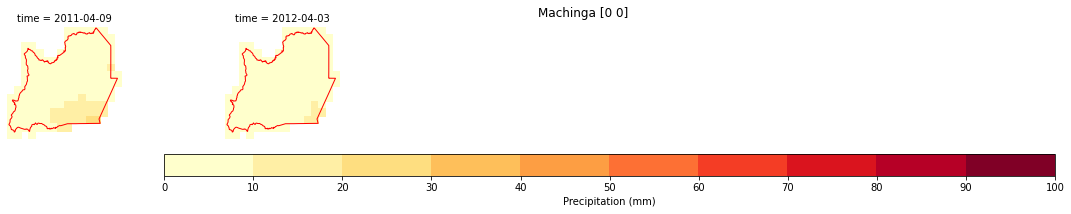

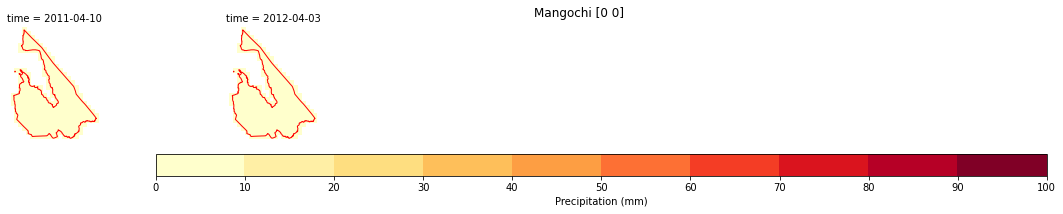

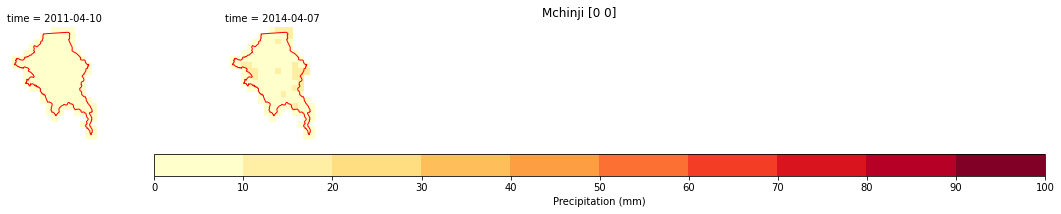

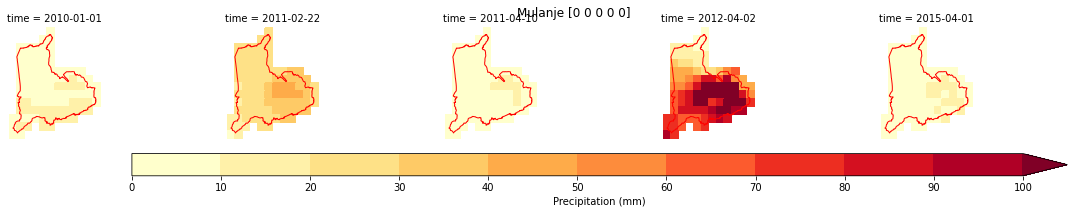

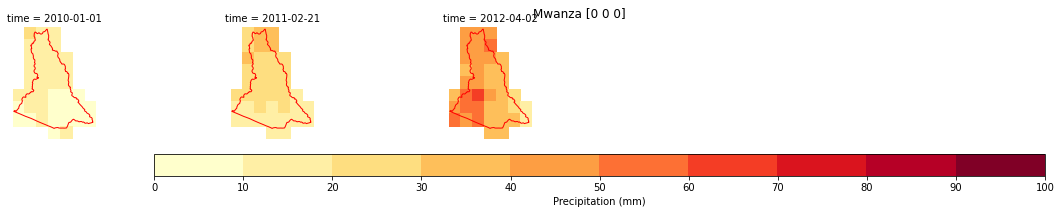

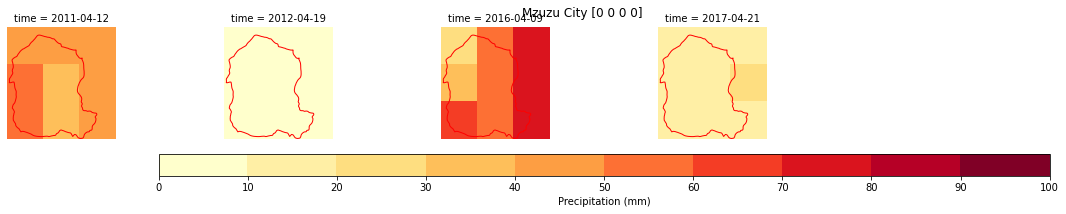

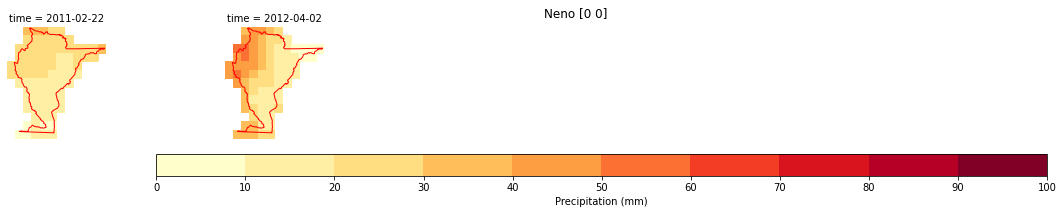

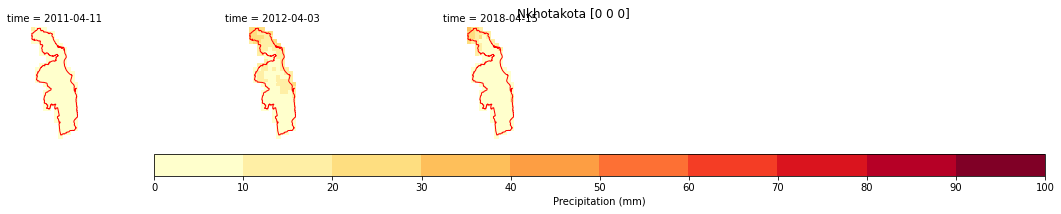

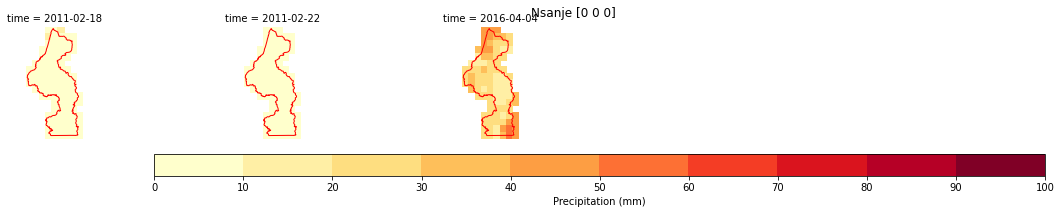

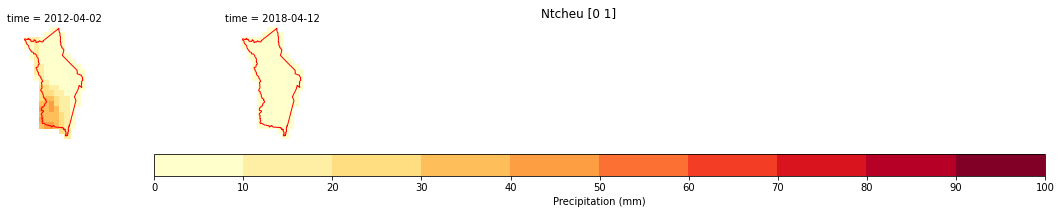

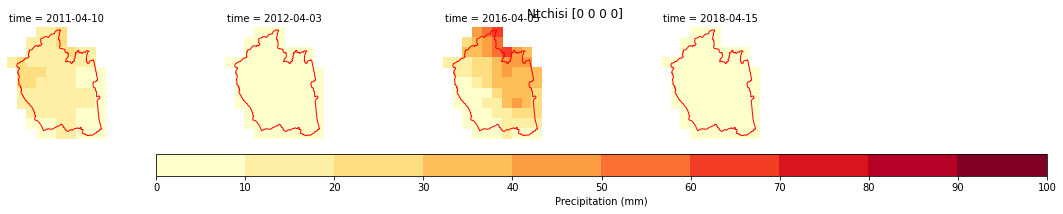

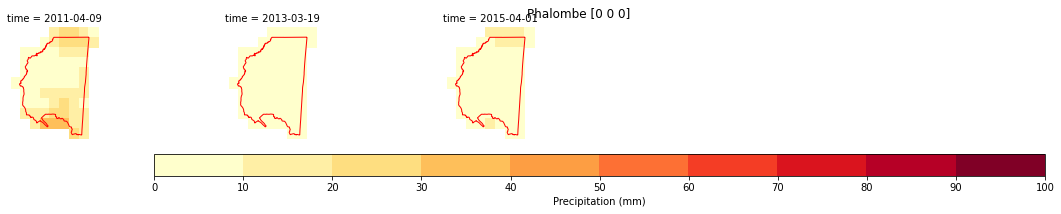

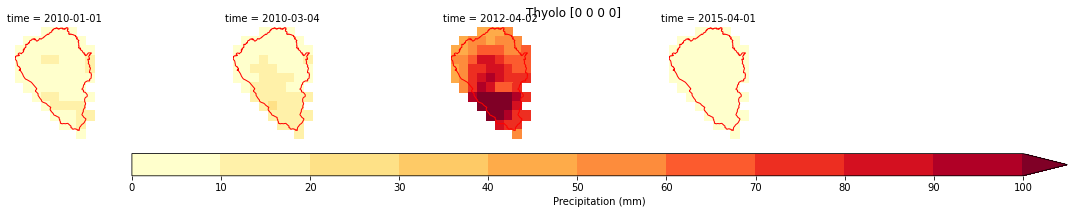

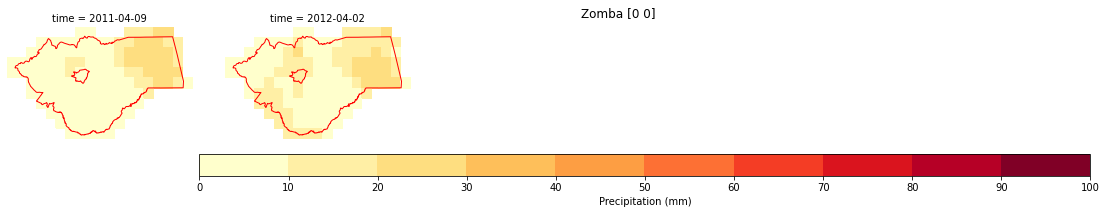

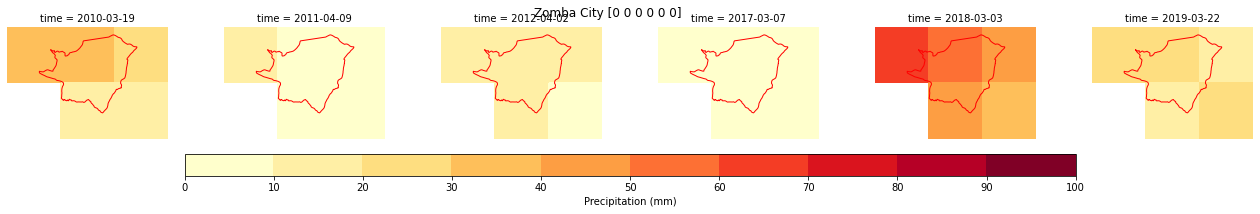

In [131]:
df_comb_ds=df_comb[df_comb.dryspell_obs==1]
for a in df_comb_ds.ADM2_EN.unique():
    print(a)
    df_bound_sel_adm=df_bound_adm2[df_bound_adm2.ADM2_EN==a]
    ds_drys_clip_adm = ds_drys.rio.clip(df_bound_sel_adm.geometry.apply(mapping), df_bound_sel_adm.crs, all_touched=True)
    ds_drys_clip_adm_dates=ds_drys_clip_adm.sel(time=ds_drys_clip_adm.time.isin(df_comb_ds[df_comb_ds.ADM2_EN==a].date.unique()))
    #cannot make the facetgrid if only one occurence. For now leave them out since just exploration, but for completeness should somehow include them
    if len(ds_drys_clip_adm_dates.time)>1:
        g=ds_drys_clip_adm_dates.plot(
        col="time",
        col_wrap=6,
        levels=bins,
        cbar_kwargs={
            "orientation": "horizontal",
            "shrink": 0.8,
            "aspect": 40,
            "pad": 0.1,
            "label":"Precipitation (mm)",
            "ticks": bins
        },
        cmap="YlOrRd",
    )

        # df_bound = gpd.read_file(adm1_bound_path)
        for ax in g.axes.flat:
            df_bound_sel_adm.boundary.plot(linewidth=1, ax=ax, color="red")
            ax.axis("off")
        g.fig.suptitle(f"{a} {df_comb_ds[df_comb_ds.ADM2_EN==a].sort_values(by='date').dryspell_forec.values}")

In [129]:
# # ### Old experiments

# #inspect difference min and max cell touched
# #plot data of Balaka for 2011
# fig,ax=plt.subplots()
# df_comb[(df_comb.date.dt.year==2011)&(df_comb.ADM2_EN=="Balaka")].sort_values(by="date").plot(x="date",y="max_cell_touched" ,figsize=(16, 8), color='red',legend=True,ax=ax)
# df_comb[(df_comb.date.dt.year==2011)&(df_comb.ADM2_EN=="Balaka")].sort_values(by="date").plot(x="date",y="min_cell_touched" ,figsize=(16, 8), color='green',legend=True,ax=ax)

# # Set x-axis label
# ax.set_xlabel("Start date", labelpad=20, weight='bold', size=12)

# # Set y-axis label
# ax.set_ylabel("mm of rain", labelpad=20, weight='bold', size=12)

# # Despine
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.spines['left'].set_visible(False)
# ax.spines['bottom'].set_visible(False)

# plt.title(f"Forecasted rainfall Balaka 2011")


# # ##### Test how many days should be included

# # #path to data start and end rainy season
# # df_rain=pd.read_csv(os.path.join(country_data_processed_dir,"dry_spells","rainy_seasons_detail_2000_2020.csv"))
# # df_rain["onset_date"]=pd.to_datetime(df_rain["onset_date"])
# # df_rain["cessation_date"]=pd.to_datetime(df_rain["cessation_date"])


# # #set the onset and cessation date for the seasons with them missing (meaning there was no dry spell data from start/till end of the season)
# # df_rain_filled=df_rain.copy()
# # df_rain_filled[df_rain_filled.onset_date.isnull()]=df_rain_filled[df_rain_filled.onset_date.isnull()].assign(onset_date=lambda df: pd.to_datetime(f"{df.season_approx.values[0]}-11-01"))
# # df_rain_filled[df_rain_filled.cessation_date.isnull()]=df_rain_filled[df_rain_filled.cessation_date.isnull()].assign(cessation_date=lambda df: pd.to_datetime(f"{df.season_approx.values[0]+1}-07-01"))


# # #remove the adm2-date entries outside the rainy season for that specific adm2
# # #before we included all forecasts within the min start of the rainy season and max end across the whole country
# # total_days=0
# # list_hist_rain_adm2=[]
# # for a in df_rain.ADM2_EN.unique():
# #     dates_adm2=pd.Index([])
# #     for i in df_rain_filled.season_approx.unique():
# #         seas_range=pd.date_range(df_rain_filled[(df_rain_filled.ADM2_EN==a)&(df_rain_filled.season_approx==i)].onset_date.values[0],df_rain_filled[(df_rain_filled.ADM2_EN==a)&(df_rain_filled.season_approx==i)].cessation_date.values[0])
# #         dates_adm2=dates_adm2.union(seas_range)
# #         total_days+=len(dates_adm2)
# # #     list_hist_rain_adm2.append(df_hist_all[(df_hist_all.ADM2_EN==a)&(df_hist_all.date.isin(dates_adm2))])
# # # df_hist_rain_adm2=pd.concat(list_hist_rain_adm2)


# # total_days/32


